# Exploração do Notebook 5

Importando os pacotes necessários:

In [1]:
from astropy.io import fits
import os
import numpy as np
from astropy.table import Table, Column, MaskedColumn
import matplotlib.pyplot as plt
import pandas as pd

Abrindo o fits:

In [2]:
dados_dir = 'specz_catalog_XIIIecbpf.fits'

hdul = fits.open(dados_dir, ignore_missing_end=True) 
data = hdul[1].data # table extensions can't be the first extension, so there's a dummy image extension at 0
cat_table = Table(data)
cols=cat_table.columns
# print(data)
print(cols)

<TableColumns names=('ra','dec','class','z','zErr','petroMag_u','petroMagErr_u','petroMag_g','petroMagErr_g','petroMag_r','petroMagErr_r','petroMag_i','petroMagErr_i')>


Gerando o dataframe e arrumando algumas entradas 'ruins':

In [3]:
df1 = cat_table.to_pandas()

df1 = df1.drop(df1[df1['class']!='GALAXY'].index) #dropando as estrelas. 
df1 = df1.drop('class', axis=1) #dropando a coluna class.
df1 = df1.replace(['null    ', 'null        ', 'null        '], np.NaN) #substituindo null por NaN.
df1 = df1.astype(float) #convertendo as entradas da tabela para float.
df1[df1['petroMag_u'] < 0] = np.NaN #filtrando magnitudes negativas.
df1[df1['petroMag_g'] < 0] = np.NaN #filtrando magnitudes negativas
df1[df1['petroMag_r'] < 0] = np.NaN #filtrando magnitudes negativas.
df1[df1['petroMag_i'] < 0] = np.NaN #filtrando magnitudes negativas.

df = df1.dropna(axis=0)

print(df.isnull().sum())

ra               0
dec              0
z                0
zErr             0
petroMag_u       0
petroMagErr_u    0
petroMag_g       0
petroMagErr_g    0
petroMag_r       0
petroMagErr_r    0
petroMag_i       0
petroMagErr_i    0
dtype: int64


Salvando em um arquivo fits e abrindo o novo arquivo:

In [4]:
new_table1 = Table.from_pandas(df)
tabela_exercicio_1 = os.path.join("arquivosgerados",'NewLegacyCatalog.fits')
hdu = fits.BinTableHDU(data=new_table1)
hdu.writeto(tabela_exercicio_1, overwrite=True)

hdul = fits.open("arquivosgerados/NewLegacyCatalog.fits", ignore_missing_end=True)

data = hdul[1].data # table extensions can't be the first extension, so there's a dummy image extension at 1
cat_table = Table(data)
cols=cat_table.columns
print(cat_table)
print(cols)

    ra        dec          z      ... petroMagErr_r petroMag_i petroMagErr_i
--------- ------------ ---------- ... ------------- ---------- -------------
146.62282  -0.95138526  0.3711277 ...    0.03089815   18.05202    0.03665525
146.59272  -0.76025604 0.06495924 ...    0.01007535   16.50206    0.01019981
 146.9108 -0.074559356  0.2422717 ...    0.03387981   17.43746    0.04512536
146.44831  -0.71339967  0.1146981 ...   0.009233744   17.02182   0.008778921
146.78847  -0.31065752 0.05656198 ...    0.03382286   17.86618    0.03925543
146.09369  -0.79308773 0.06758517 ...   0.005180169   15.43335   0.004949708
146.09369  -0.79308773 0.06762055 ...   0.005180169   15.43335   0.004949708
      ...          ...        ... ...           ...        ...           ...
16.063257    -1.114314 0.01798435 ...   0.004130061   14.40654    0.00436022
15.844699  -0.67906213  0.2059941 ...    0.01499067   18.41356    0.01536485
15.770648  -0.37314851  0.0648139 ...    0.03448401   17.40179    0.04046607

Plotando as magnitudes:

<function matplotlib.pyplot.show(close=None, block=None)>

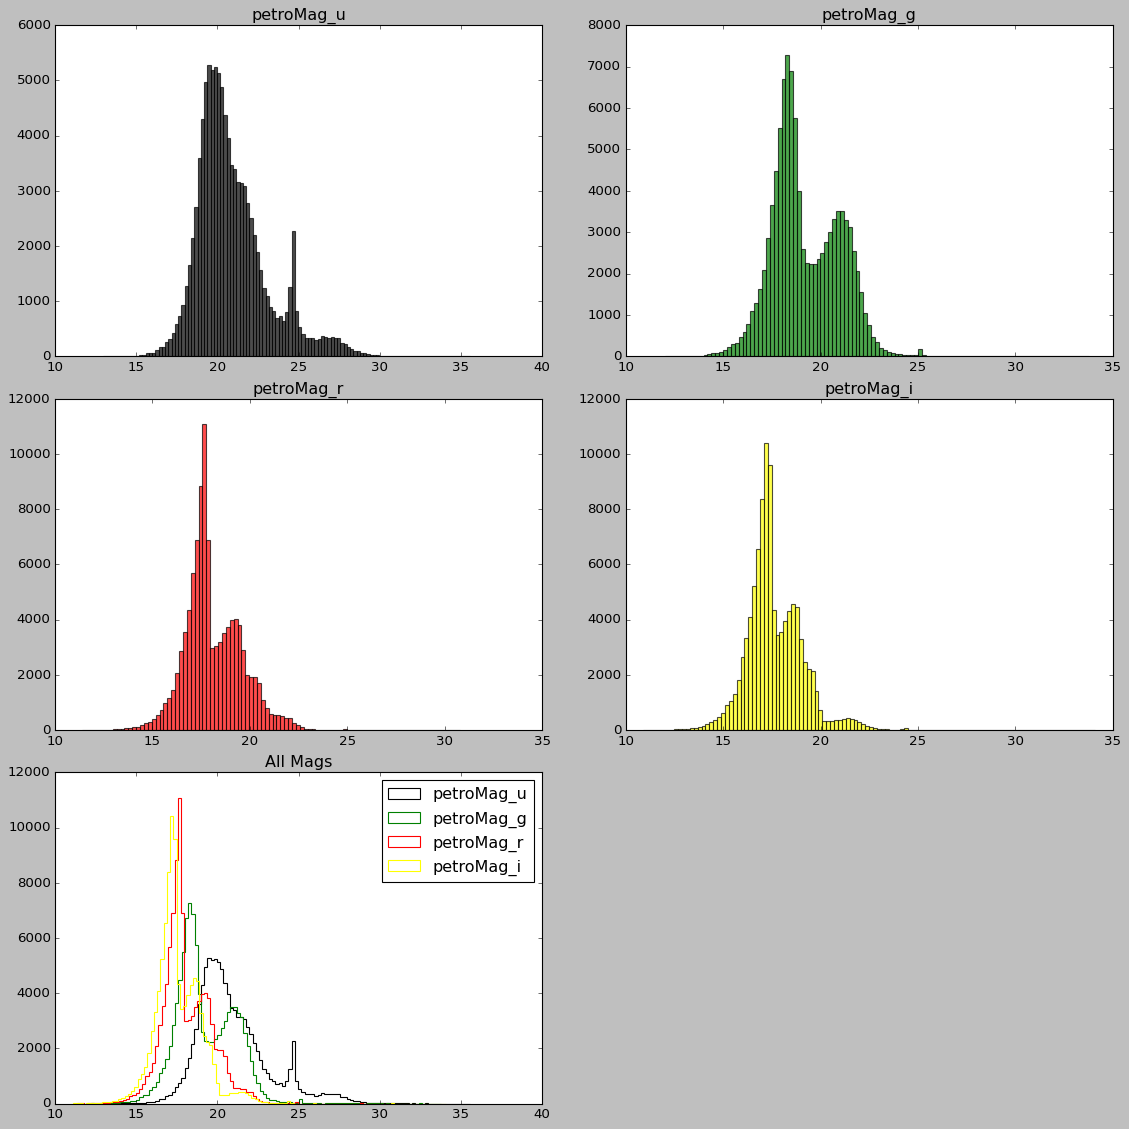

In [5]:
### MAG PLOTS

mags = ['petroMag_'+band for band in 'ugri']

key_list = mags 
color_list = ['black', 'green', 'red', 'yellow']
hor = 2
ver = 3

plt.style.use('classic')

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

i=0
binsize=0.2
def binarange(arr):
    return np.arange(min(arr), max(arr)+binsize, binsize)


for v in range(ver):
    for h in range(hor):
        if v==2:
                     
            ax = fig.add_subplot(gs[v, 0])
            for c, key in enumerate(key_list):
                bins = binarange(data.field(key))
                ax.hist(data.field(key), bins=bins, color=color_list[c], alpha=1, label=key, histtype='step')
            ax.set_title("All Mags")
            plt.legend()
            
            break
            i+=1
        
        
        mags = ['petroMag_'+band for band in 'ugri']
        
        ax = fig.add_subplot(gs[v, h])
        bins = binarange(data.field(key_list[i]))
        ax.hist(data.field(key_list[i]), bins=bins, color=color_list[i], alpha=0.7)
        ax.set_title(key_list[i])
        i+=1

plt.show

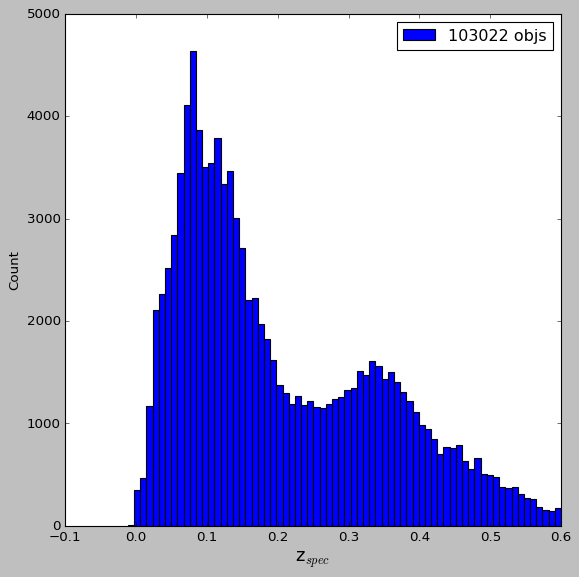

In [6]:
#ZSPEC PLOTS

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.hist(np.array(data.field('z')), bins=70, color='blue', label=f'{len(data)} objs')
ax.set_xlabel('z$_{spec}$', fontsize=16)
ax.set_ylabel('Count')
plt.legend()

In [7]:
#preprocessing

from sklearn.preprocessing import MinMaxScaler
np.random.seed(42)

train_percentual = 7/10
train_cut = np.random.uniform(0, 1, len(data)) < train_percentual
train_data = data[train_cut]

test_val_data = data[~train_cut]

test_percentual = 2/3
test_cut = np.random.uniform(0, 1, len(test_val_data)) < test_percentual

test_data = test_val_data[test_cut]
val_data = test_val_data[~test_cut]

print(f'Train Percent = {len(train_data)/len(data)*100:.2f}%')
print(f'Test Percent = {len(test_data)/len(data)*100:.2f}%')
print(f'Val Percent = {len(val_data)/len(data)*100:.2f}%')

#embaralhando os dados

train_shuffler = np.random.choice(len(train_data), len(train_data), replace=False)
train_data = train_data[train_shuffler]

test_shuffler = np.random.choice(len(test_data), len(test_data), replace=False)
test_data = test_data[test_shuffler]

val_shuffler = np.random.choice(len(val_data), len(val_data), replace=False)
val_data = val_data[val_shuffler]


x_train = np.array([train_data.field(mag) for mag in mags]).T
y_train = np.array(train_data.field('z'))

x_test = np.array([test_data.field(mag) for mag in mags]).T
y_test = np.array(test_data.field('z'))

x_val = np.array([val_data.field(mag) for mag in mags]).T
y_val = np.array(val_data.field('z'))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

np.max(x_test[:, 1])
print(train_data)

Train Percent = 70.12%
Test Percent = 19.94%
Val Percent = 9.94%
[(148.30764 , 33.042972 , 0.3607461 , 7.221261e-05, 21.67804, 0.6841317 , 20.54196, 0.1181228 , 18.76517, 0.1665299 , 18.17455, 0.1371626 )
 (204.77267 , 58.349234 , 0.04083487, 8.414133e-06, 18.9649 , 0.07395827, 17.68188, 0.01070401, 17.05698, 0.00911643, 16.75284, 0.01132381)
 (119.97601 , 32.191191 , 0.07035409, 7.432306e-06, 18.84383, 0.05733196, 17.5416 , 0.0099202 , 16.97059, 0.00877133, 16.6053 , 0.0092192 )
 ...
 (341.05679 , 28.365406 , 0.06595091, 1.500599e-05, 19.54905, 0.09584501, 17.74508, 0.01039567, 16.81249, 0.00904732, 16.34808, 0.00956729)
 (233.65954 , 58.56429  , 0.06693009, 1.735685e-05, 19.38061, 0.09446165, 17.99742, 0.0135186 , 17.27397, 0.01182944, 16.90539, 0.01266549)
 ( 39.005675, -6.7298554, 0.3744694 , 7.883919e-05, 24.5712 , 4.399933  , 20.92286, 0.1099424 , 19.24647, 0.051382  , 18.58595, 0.05323315)]


In [ ]:
import tensorflow.keras as keras
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"


def build_model(input_shape, nb_classes=1):
    input_layer = keras.layers.Input(input_shape)

    layer_1 = keras.layers.Dense(512, activation='relu')(input_layer)
    layer_1= keras.layers.Dropout(rate=0.2)(layer_1)

    layer_2 = keras.layers.Dense(256, activation='relu')(layer_1)
    layer_2 = keras.layers.Dropout(rate=0.2)(layer_2)

    layer_3 = keras.layers.Dense(128, activation='relu')(layer_2)
    layer_3 = keras.layers.Dropout(rate=0.2)(layer_3)

    output_layer = keras.layers.Dense(units=nb_classes,activation='linear')(layer_2)


    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

regressor = build_model(x_train.shape[1:])
regressor.compile(loss='mse', optimizer=keras.optimizers.Nadam(), metrics=['accuracy'])


batch_size = 128
epochs = 2

history = regressor.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                     verbose=1, validation_data=(x_val,y_val))

preds = regressor.predict(x_test)

In [ ]:
# TRAINING PLOTS

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epochs')
plt.ylabel('loss (mse)')
plt.legend()
plt.tight_layout()

In [ ]:
### CALCULO DAS MÉTRICAS E PLOTS
def get_zstatistic(z,zspec):
    deltaz=z-zspec
    mean_bias=np.mean(deltaz)

    p16=np.percentile(deltaz,15.85)
    p84=np.percentile(deltaz,84.05)
    sigma68=0.5*(p84-p16)
    median_bias=np.percentile(deltaz,50)
    return mean_bias,median_bias,sigma68
    

def redshift_plot(z, zspec):
    plt.style.use('default')
    fig = plt.figure(figsize=(10, 8))
    #mean_bias,median_bias,sigma68=get_zstatistic(z, zspec)
    #text="\n $\sigma_{68}$: $"+str(round(sigma68,3))+"$"
    #text+="\n Mean Bias: $"+str(round(mean_bias,3))+"$"
    #text+="\n Median Bias: $"+str(round(median_bias,3))+"$"
    ax = fig.add_subplot()
    
    #dispersão entre photo-z e spec-z
    ax.scatter(zspec, z, alpha = 0.5, s=8, marker='o')
    
    #reta x = y
    reta = [0, max([max(zspec), max(z)])]
    ax.plot(reta, reta, ls='dashed', color='black', lw=0.5)
    
    #limites e legendas
    ax.set_ylim(min(z),max(z))
    ax.set_xlim(0,max(zspec))
    ax.set_ylabel("$z_{phot}$", fontsize=15)
    ax.set_xlabel("$z_{spec}$", fontsize=15)
    #ax.text(0.7*max(zspec), .2*max(z), text, va="top", fontsize=12)
    plt.show()


In [ ]:
preds

In [ ]:
print(len(preds))
print(len(y_test))

redshift_plot(preds, y_test)

#get_zstatistic(preds,y_test) - Dando problema!